In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
from tf_conversions import posemath
import time

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
rospy.init_node('notebook')

In [3]:
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/warning', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/

In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

# while left_image is None or right_image is None:
#     print("left or right image not receieved")
#     time.sleep(0.5)

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU3RvcCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCkpLCBPdXRwdXQobGF5b3V0PUxheW91dChib3JkZXLigKY=


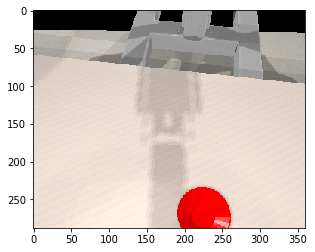

In [5]:
plt.imshow(left_image)

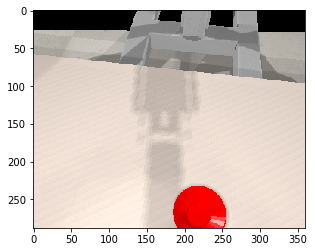

In [6]:
plt.imshow(right_image)

In [7]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 5198
  stamp: 
    secs: 1619659469
    nsecs:  16350746
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 5198
  stamp: 
    secs: 1619659469
    nsecs:  16350746
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  

In [ ]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, psm2, psm3, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    psm2 = dvrk.psm('PSM2')
    psm3 = dvrk.psm('PSM3')
    
    psm1_suj = dvrk.suj('PSM1')
    psm2_suj = dvrk.suj('PSM2')
    psm3_suj = dvrk.suj('PSM3')
    ecm_suj = dvrk.suj('ECM')
    
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [ ]:
tf_listener = tf.TransformListener()
time.sleep(5)

In [ ]:
tf_listener.getFrameStrings()

In [11]:
from math import radians as r

# start position

# sm1 = [0.5, -2.4958207607269287, 2.775073528289795, 0.13962633907794952, -0.5235987901687622]
# sm2 = [0.5, 2.6005406379699707, -2.7227137088775635, -0.20943951606750488, -0.7155849933624268]
# sm3 = [0.5, 2.3212878704071045, -1.378810167312622, -1.5707963705062866, -0.8901179432868958]
# cm = [1.0, -1.2042771577835083, 2.687807083129883, -1.4311699867248535]

sm1 = [0.0, -1.5, 1.8, 0.1, -0.9]
sm2 = [0.0, 1.5, -1.8, -0.1, -0.9]
sm3 = [0.2, 2, -2.3, -0.1, -1.3]
cm = [0.52, 0.6, -1.6, 1.0]

psm1_suj.move_joint(np.asarray(sm1))
psm2_suj.move_joint(np.asarray(sm2))
psm3_suj.move_joint(np.asarray(sm3))
ecm_suj.move_joint(np.asarray(cm))

print(psm1_suj.get_current_joint_position())
print(psm2_suj.get_current_joint_position())
print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())
print('----------------------------------')
print(psm1_suj.get_current_position())
print(psm2_suj.get_current_position())
print(psm3_suj.get_current_position())
print(ecm_suj.get_current_position())

[ 0.08       -1.22173047  1.57079637  0.17453292  0.        ]
[ 0.08        1.22173047 -1.57079637 -0.17453292  0.        ]
[ 0.5         2.21656823 -1.4486233  -1.57079637 -1.01229095]
[ 0.60000002  0.78539819 -1.57079637  0.78539819]
----------------------------------
[[ 3.33067e-16,          -1,           0;
            1, 3.33067e-16,           0;
            0,           0,           1]
[     -1.9501,   -0.101602,      0.9088]]
[[ 3.33067e-16,           1,           0;
           -1, 3.33067e-16,          -0;
           -0,           0,           1]
[      1.9501,   -0.101598,      0.9088]]
[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[-1.50197e-06,      2.0009,      0.9163]]
[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]


In [13]:
#a=height,b=shoulder J1,c=elbow J2,d=wrist J3
def move_ecm_suj(a, b, c, d, e, f):
    ecm_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_ecm_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuNSwgZGVzY3JpcHRpb249dSdhJywgbWF4PTEuMCksIEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2InLCDigKY=


In [14]:
def move_psm1_suj(a, b, c, d, e, f):
    psm1_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm1_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuNSwgZGVzY3JpcHRpb249dSdhJywgbWF4PTEuMCksIEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2InLCDigKY=


In [15]:
def move_psm2_suj(a, b, c, d, e, f):
    psm2_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm2_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuNSwgZGVzY3JpcHRpb249dSdhJywgbWF4PTEuMCksIEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2InLCDigKY=


In [16]:
def move_psm3_suj(a, b, c, d, e, f):
    psm3_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm3_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuNSwgZGVzY3JpcHRpb249dSdhJywgbWF4PTEuMCksIEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2InLCDigKY=


In [12]:
#Home PSMs and ECM
HARDCODED_ECM_POS = np.asarray([-0.6, -0.45, 0.5, 0.0 ])
ecm.move_joint(HARDCODED_ECM_POS)
#PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
time.sleep(1)

#psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

#psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

#psm3.move_joint(PSM_HOME_POS)
psm3.close_jaw()

True

[   -0.985709,   0.0040838,     1.04433]


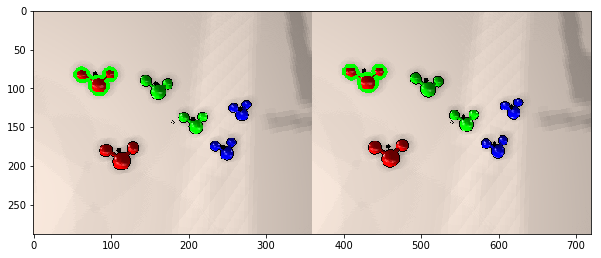

In [17]:
pick_and_place_utils = None
from pick_and_place_utils import get_objects_and_img, tf_to_pykdl_frame, PSM_J1_TO_BASE_LINK_TF
import image_geometry

stereo_cam = image_geometry.StereoCameraModel()
stereo_cam.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))
tf_world_to_psm1 = \
    tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))

objects, left_frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)

ball_pos_cam = objects[0].pos
print(ball_pos_cam)

plt.figure(figsize=(10, 5))
plt.imshow(left_frame)
# depth error experiments
# (-0.02772727272727273, 0.009545454545454546, 0.14180015986663413) {-0.02987164259, 0.01018744707, 0.1481492519}
# (-0.028636363636363637, 0.01, 0.14180015986663413) {-0.02869459987, 0.009940028191, 0.1379978657} 
# (-0.013333333333333334, 0.010416666666666666, 0.12998347987774794) {-0.01380112767, 0.009659290314, 0.1300171614} 
# (0.04038461538461539, 0.008076923076923077, 0.11998475065638273) {-0.009348809719, 0.01096570492, 0.1307697296} 

In [26]:
ball_pos_cam = PyKDL.Vector(*ball_pos_cam)

#tf_insertion_to_cam = \
#    tf_listener.lookupTransform('ecm_pitch_link_1', 'camera', now)#rospy.Time())

tf_listener.waitForTransform('ecm_pitch_link_1', 'camera', rospy.Time(), rospy.Duration(10.0))
tf_insertion_to_cam = \
    tf_listener.lookupTransform('ecm_pitch_link_1', 'camera', rospy.Time()



tf_cam_to_jp21 = tf_to_pykdl_frame(tf_insertion_to_cam)
ball_pos_jp21 = tf_cam_to_jp21 * ball_pos_cam
ball_pos_jp21

TransformException: Lookup would require extrapolation into the past.  Requested time 1619657277.639238119 but the earliest data is at time 1619658577.381551027, when looking up transform from frame [camera] to frame [ecm_pitch_link_1]

In [20]:
# did this to confirm that the /tf transforms provided by dVRK are within margin of error of 
# actual sim coordinates
tf_insertion_to_jp21 = tf_listener.lookupTransform('ecm_pitch_link_1', 'ecm_insertion_link', rospy.Time())
tf_insertion_to_jp21

([-0.3780000000000002, 0.38220000000185084, 2.7755575615628914e-17],
 [0.7071067811848165,
  -6.677109938001597e-17,
  -1.2669696976051526e-16,
  0.707106781188279])

In [21]:
tf_jp21_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('world', 'Jp21_ECM', rospy.Time()))
ball_pos_world = tf_jp21_to_world * ball_pos_jp21
# i'm a winner
ball_pos_world

[  0.00212606,   -0.096464,    0.957135]

In [22]:
tf_world_to_psm2_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'world', rospy.Time()))
ball_pos_psm2_j1 = tf_world_to_psm2_j1 * ball_pos_world
# ok not off by *too* much
ball_pos_psm2_j1

[    0.913656,   -0.158779,     1.22323]

In [23]:
ball_pos_psm2_main = PSM_J1_TO_BASE_LINK_TF * ball_pos_psm2_j1
ball_pos_psm2_main

[   -0.913656,    -1.22323,    0.158779]

#### 

In [24]:
psm2_rot = psm2.get_current_position().M
psm2_pos = psm2.get_current_position().p
psm2_pos

[ 1.59784e-07, 1.93211e-07,     -0.0435]

In [25]:
psm2.move(ball_pos_psm2_main)

True

In [26]:
cam_z_vec_world = (tf_jp21_to_world * tf_cam_to_jp21).M * PyKDL.Vector(0, 0, 1.0)
cam_z_vec_psm2_main = (PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm2_j1).M * cam_z_vec_world

In [27]:
psm2.move_joint_one(0., 5)
psm2.open_jaw()
psm2.dmove(0.03 * cam_z_vec_psm2_main)
psm2.close_jaw()

True

In [28]:
psm2.dmove( PyKDL.Vector(0, 0, 0.1))

True

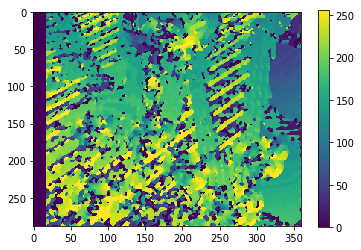

In [29]:
stereo = cv2.StereoSGBM_create(minDisparity=1, numDisparities=16, blockSize=5)

left_image_bw = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_bw = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)
disparity_map = stereo.compute(left_image_bw, right_image_bw)
plt.imshow(disparity_map)
plt.colorbar()

[[[122   0]]

 [[121   1]]

 [[121   2]]

 [[120   3]]

 [[120   4]]

 [[119   5]]

 [[119   6]]

 [[118   7]]

 [[118  10]]

 [[117  11]]

 [[117  21]]

 [[118  22]]

 [[118  23]]

 [[119  24]]

 [[119  26]]

 [[120  27]]

 [[120  28]]

 [[122  30]]

 [[122  31]]

 [[126  35]]

 [[126  36]]

 [[127  36]]

 [[130  39]]

 [[131  39]]

 [[134  42]]

 [[135  42]]

 [[136  43]]

 [[137  43]]

 [[138  44]]

 [[139  44]]

 [[140  45]]

 [[141  45]]

 [[142  46]]

 [[144  46]]

 [[145  47]]

 [[147  47]]

 [[148  48]]

 [[150  48]]

 [[151  49]]

 [[153  49]]

 [[154  50]]

 [[159  50]]

 [[160  51]]

 [[170  51]]

 [[171  52]]

 [[179  52]]

 [[180  51]]

 [[187  51]]

 [[188  50]]

 [[192  50]]

 [[193  49]]

 [[196  49]]

 [[197  48]]

 [[199  48]]

 [[200  47]]

 [[203  47]]

 [[204  46]]

 [[205  46]]

 [[206  45]]

 [[207  45]]

 [[208  44]]

 [[209  44]]

 [[210  43]]

 [[211  43]]

 [[212  42]]

 [[213  42]]

 [[214  41]]

 [[215  41]]

 [[218  38]]

 [[219  38]]

 [[228  29]]

 [[228

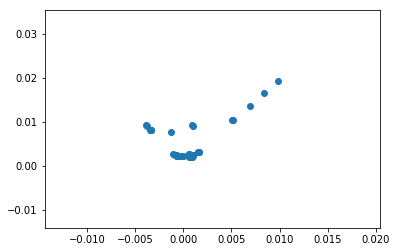

In [30]:
from feature_processor import feature_processor
from pick_and_place_utils import FEAT_PATHS, CV_TO_CAM_FRAME_ROT
fp = feature_processor(FEAT_PATHS)
feats, frame = fp.FindImageFeatures(left_image_msg)
bowl = max(feats, key=lambda feat : cv2.contourArea(feat.contour))
bowl_pts_cam = []
print(bowl.contour)

for pt_ in bowl.contour:
    pt = tuple(np.clip(pt_[0], (0, 0), np.array(left_image_bw.shape) - np.array([1, 1])))
    disparity = disparity_map[pt]
    if disparity < 1:
        continue
    print(disparity)
    cam_xyz = stereo_cam.projectPixelTo3d(pt, disparity)
    cam_pt = np.matmul(CV_TO_CAM_FRAME_ROT, cam_xyz)
    bowl_pts_cam.append(PyKDL.Vector(*cam_pt))

plt.scatter([pt[0] for pt in bowl_pts_cam], [pt[1] for pt in bowl_pts_cam])

In [31]:
import plotly
import plotly.graph_objects as go 

plotly.offline.init_notebook_mode()
trace = go.Scatter3d(
    x = [pt[0] for pt in bowl_pts_cam],
    y = [pt[1] for pt in bowl_pts_cam],
    z = [pt[2] for pt in bowl_pts_cam],
    mode = 'markers', 
    marker = {
            'size': 5,
            'opacity': 0.8,
        })

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}

)

data = [trace]
plot_figure = go.Figure(data=data, layout=layout)
plotly.offline.iplot(plot_figure)
# StereoSGBM officially a failed experiment
# the point cloud plot is pretty cool though

In [31]:
from feature_processor import FeatureType
bowl_obj = None
for obj in objects:
    if obj.type == FeatureType.BOWL:
        bowl_obj = obj
bowl_obj.pos

[    -1.54133, -0.00296429,    0.672683]

In [32]:
bowl_pos_cam = PyKDL.Vector(*bowl_obj.pos)
bowl_pos_world = tf_jp21_to_world * (tf_cam_to_jp21 * bowl_pos_cam)
bowl_pos_psm2_main = PSM_J1_TO_BASE_LINK_TF * (tf_world_to_psm2_j1 * bowl_pos_world)
# add a little bit to the z-axis to avoid hitting the bowl
dest_psm2 = bowl_pos_psm2_main + PyKDL.Vector(0, 0, 0.1)
psm2.move(dest_psm2)
psm2.open_jaw()

True